# COVID-19 data analysis

<img src=coronavirus-DNA-720.png  width="1200" >

In [60]:
#see online at https://covid19-jyy3.onrender.com/analysis

In [61]:
#Download world dataset
!curl https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv -o deaths_global.csv 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47329  100 47329    0     0  45377      0  0:00:01  0:00:01 --:--:-- 45334


In [62]:
#keep Italian repository update
!git pull https://github.com/pcm-dpc/COVID-19.git master --no-edit

From https://github.com/pcm-dpc/COVID-19
 * branch            master     -> FETCH_HEAD
Already up-to-date.


In [63]:
#libraries
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import date2num
import gc
plt.style.use('ggplot')

In [64]:
#suppress annoying warnings about pandas assignment
pd.options.mode.chained_assignment = None
#suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [65]:
#format x axis with dates
def format_x_date(ax):
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))





def get_country_data(selection):
    selection = selection.iloc[:,4:].T
    selection.columns=['Death']
    selection['Death_change']=selection['Death']-selection['Death'].shift(1)
    selection=selection.reset_index()
    selection['index'] = pd.to_datetime(selection['index'])
    selection['Death_change_log']=np.log10(selection['Death_change'])
    selection['Death_change_log']=selection['Death_change_log'].replace(-np.inf,np.nan)
    selection=selection[~selection['Death_change_log'].isna()]
    selection.columns=['date']+list(selection.columns[1:])
    selection['ndate']=date2num(selection['date'])
    return selection



# Load national dataset

In [66]:
df = pd.read_csv(os.path.join('dati-andamento-nazionale',
                               'dpc-covid19-ita-andamento-nazionale.csv'))
df.data = pd.to_datetime(df.data)
#assuming terapia_intensiva (intensive care) and deceduti (deaths)
#are cumulative. It is not specified in the dataset.
#Computing Daily new cases
df['ricoverati_con_sintomi_change']=df['ricoverati_con_sintomi']-df['ricoverati_con_sintomi'].shift(1)
df['terapia_intensiva_change']=df['terapia_intensiva']-df['terapia_intensiva'].shift(1)
df['deceduti_daily']=df['deceduti']-df['deceduti'].shift(1)


#The number of deaths over the number 
#of new cases admitted in intensive care (daily)
df['not_admitted_ratio'] = df['deceduti_daily']/(df['terapia_intensiva_change'])
#The number of deaths minus the number 
#of new cases admitted in intensive care (daily)
df['not_admitted'] = df['deceduti_daily']-(df['terapia_intensiva_change'])

#remove unused
df.drop(['stato'],axis=1,inplace=True)
df.drop(['data'],axis=1).tail()

#compute log of selected columns
cols = ['nuovi_positivi',#new positive case now
          'deceduti_daily',#today deaths
          'terapia_intensiva',#Intensive care
          'deceduti'#deaths
         ]
for c in cols:
    
    df[c+'_log']=np.log10(df[c])
df[cols+['deceduti_daily_log']].head(5)

,nuovi_positivi,deceduti_daily,terapia_intensiva,deceduti,deceduti_daily_log
0,221,NaN,26,7,NaN
1,93,3.0,35,10,0.477121
2,78,2.0,36,12,0.301030
3,250,5.0,56,17,0.698970
4,238,4.0,64,21,0.602060


In [67]:
df.tail()

,data,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,...,note_en,ricoverati_con_sintomi_change,terapia_intensiva_change,deceduti_daily,not_admitted_ratio,not_admitted,nuovi_positivi_log,deceduti_daily_log,terapia_intensiva_log,deceduti_log
35,2020-03-30 17:00:00,27795,3981,31776,43752,75528,1648,4050,14620,11591,...,NaN,409.0,75.0,812.0,10.826667,737.0,3.607455,2.909556,3.599992,4.064121
36,2020-03-31 17:00:00,28192,4023,32215,45420,77635,2107,4053,15729,12428,...,NaN,397.0,42.0,837.0,19.928571,795.0,3.607777,2.922725,3.604550,4.094401
37,2020-04-01 17:00:00,28403,4035,32438,48134,80572,2937,4782,16847,13155,...,NaN,211.0,12.0,727.0,60.583333,715.0,3.679610,2.861534,3.605844,4.119091
38,2020-04-02 17:00:00,28540,4053,32593,50456,83049,2477,4668,18278,13915,...,NaN,137.0,18.0,760.0,42.222222,742.0,3.669131,2.880814,3.607777,4.143483
39,2020-04-03 17:00:00,28741,4068,32809,52579,85388,2339,4585,19758,14681,...,NaN,201.0,15.0,766.0,51.066667,751.0,3.661339,2.884229,3.609381,4.166756


## Fig1 
How the death rate changes before and after the introduction of social distancing mesures in Italy?

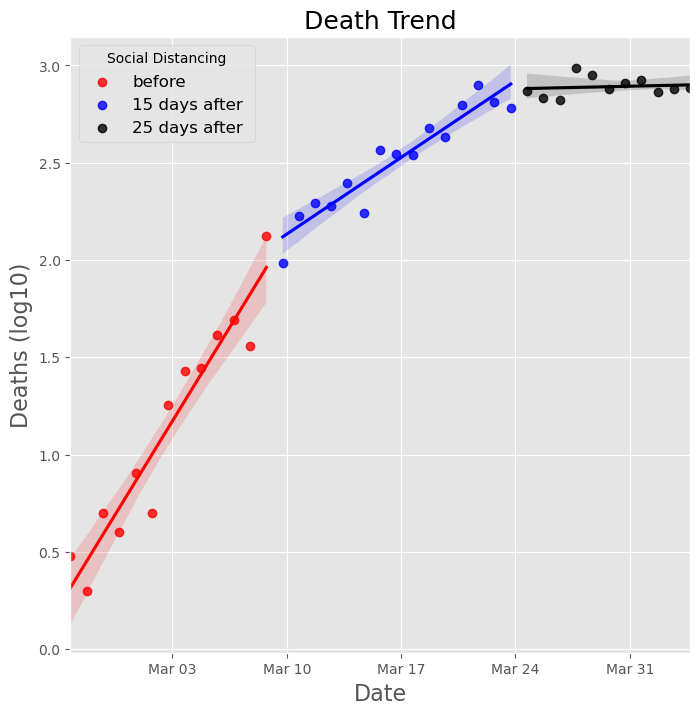

In [69]:
plt.style.use('ggplot')
before = df[df['data']<'2020-03-9']
before['ndata']=date2num(before['data'])
after = df[(df['data']>'2020-03-9') & (df['data']<'2020-03-24') ]
after['ndata']=date2num(after['data'])

after2 = df[(df['data']>='2020-03-24')  ]
after2['ndata']=date2num(after2['data'])

x='ndata'
y='deceduti_daily_log'
fig,ax=plt.subplots(figsize=(8,8))
sns.regplot(x=x, y=y, color="r", data=before,ax=ax,label='before')
sns.regplot(x=x, y=y, color="b", data=after,ax=ax,label='15 days after ')
sns.regplot(x=x, y=y, color="black", data=after2,ax=ax,label='25 days after')
format_x_date(ax)
#plt.xticks(rotation=70,ha='right')
plt.xlabel('Date', fontsize='16')
plt.ylabel('Deaths (log10)',fontsize='16')
plt.title('Death Trend',fontsize='18')
plt.legend(title='Social Distancing',fontsize=12)
plt.savefig('Fig1.png')
plt.show()

## Fig2 
How many more people die in Italy respect to the people admitted in intensive care?

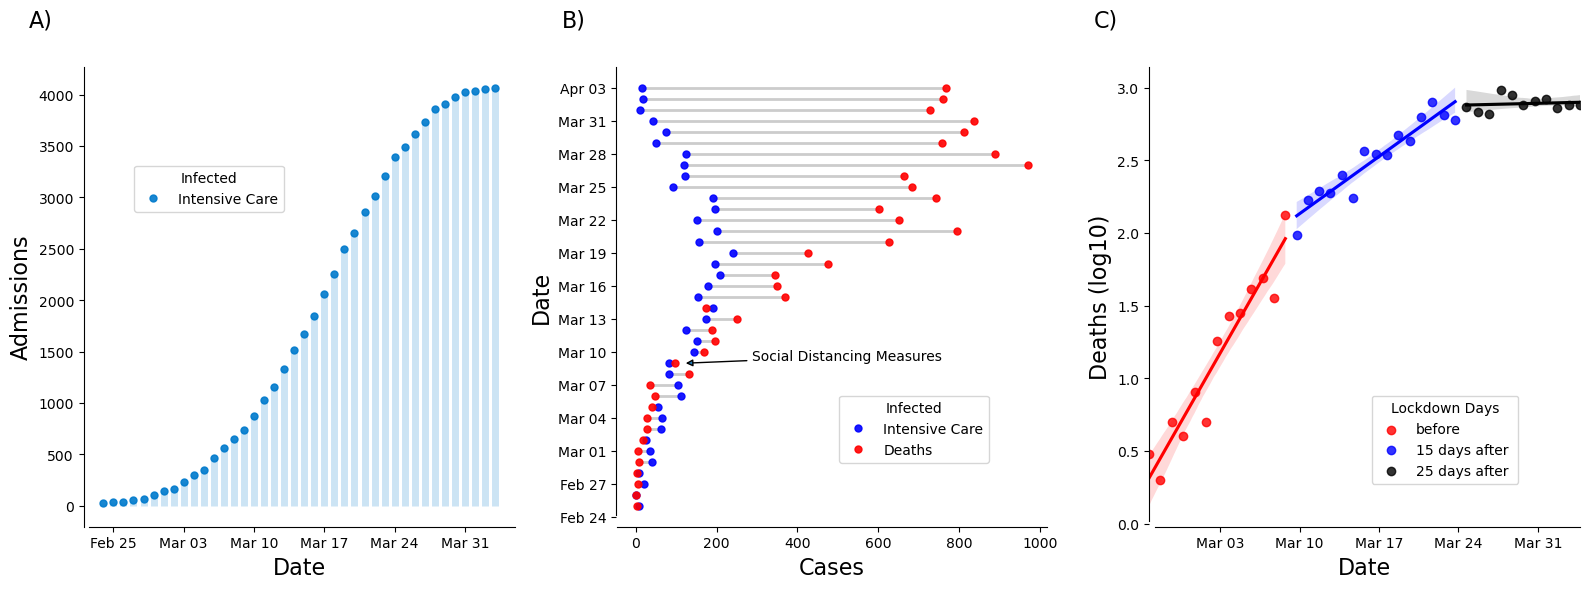

In [70]:
#plt.style.use('ggplot')

def despine(ax,log_y=False):
    small_add=1.1
    if log_y:
        small_add = np.log10(1.1)    
    ymin, ymax = ax.get_ylim()
    #ax.set_ylim(ymin+small_add,ymax)

    ax.spines['left'].set_bounds(ymin+small_add, ymax)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    xmin, xmax = ax.get_xlim()
    #ax.set_xlim(xmin,xmax)

    ax.spines['bottom'].set_bounds(xmin+0.5, xmax)
    
def lollipop_plot(df, ax, date_col='data', value_col='not_admitted_ratio',
                 color='#007acc',label='Ratio'):
    #make lollipop
    ax.plot(df[date_col].dt.date, df[value_col], "o",
        markersize=5, color=color, alpha=0.9,label=label)
    #make stick
    ax.vlines(x=df[date_col].dt.date, ymin=0, 
          ymax=df[value_col], color=color, alpha=0.2, linewidth=5)

    #set ticks every week
    despine(ax)
    format_x_date(ax)
    
    return ax

def my_plot(df, ax, date_col='data', 
            #value_3='ricoverati_con_sintomi_change',
            value_2='terapia_intensiva_change',
            value_1='deceduti_daily',
            
            label_1='Deaths',
            label_2="Intensive Care",
            #label_3="Hospital Admissions",
           ):
    #make lollipop
    #ax.plot(df[value_3], df[date_col].dt.date, "o",
    #    markersize=5, color='green', alpha=0.9,label=label_3)    
    ax.plot(df[value_2], df[date_col].dt.date, "o",
        markersize=5, color='blue', alpha=0.9,label=label_2)
    ax.plot(df[value_1], df[date_col].dt.date, "o",
        markersize=5, color='red', alpha=0.9,label=label_1)

    
    xmin=df[[value_1,value_2]].min(axis=1)
    xmax=df[[value_1,value_2]].max(axis=1)
    #make stick
    ax.hlines(y=df[date_col].dt.date, xmin=xmin,
              xmax=xmax, color='black', alpha=0.2, linewidth=2)

    
    #ymin, ymax = ax.get_ylim()
    #ax.set_ylim(ymin,ymax)
    #ax.spines['left'].set_bounds(ymin, ymax-0.5)
    despine(ax)
    #set ticks every 3 days
    #ax.yaxis.set_major_locator(mdates.WeekdayLocator())
    ax.yaxis.set_major_locator(mdates.DayLocator(interval=3))
    #set major ticks format
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

    #ax.spines['top'].set_color('none')
    #ax.spines['right'].set_color('none')
    #xmin, xmax = ax.get_xlim()
    #ax.spines['bottom'].set_bounds(0, xmax-1)
    return ax


plt.style.use('default')
from matplotlib.patches import Ellipse

fig,axes=plt.subplots(figsize=(16,6
                              ),ncols=3)

ax=axes[1]
ax = my_plot(df, ax)
df['ndate']=date2num(df['data'])

ax.set_xlabel('Cases', fontsize='16')
ax.set_ylabel('Date', fontsize='16')

ax.annotate('Social Distancing Measures', 
            (df['deceduti_daily'][14]+20, mdates.date2num(df['data'][13])+0.2 ),
            xytext=(50, 2), 
            textcoords='offset points', 
            arrowprops=dict(arrowstyle='-|>'))
ax.text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center',
               transform=ax.transAxes,fontsize=16)

ax.legend(loc=2, bbox_to_anchor=(0.5, 0.3), title='Infected')
ax=axes[0]
ax = lollipop_plot(df, ax, date_col='data',
                   value_col='terapia_intensiva',label='Intensive Care')

ax.legend(loc=2, bbox_to_anchor=(0.1, 0.8), title='Infected')

ax.set_xlabel('Date', fontsize='16')
ax.set_ylabel('Admissions', fontsize='16')
ax.text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center',
               transform=ax.transAxes,fontsize=16)


ax=axes[2]
before = df[df['data']<'2020-03-9']
before['ndata']=date2num(before['data'])
after = df[(df['data']>'2020-03-9') & (df['data']<'2020-03-24') ]
after['ndata']=date2num(after['data'])

after2 = df[(df['data']>='2020-03-24')  ]
after2['ndata']=date2num(after2['data'])

x='ndata'
y='deceduti_daily_log'
#fig,ax=plt.subplots(figsize=(8,8))
sns.regplot(x=x, y=y, color="r", data=before,ax=ax,label='before')
sns.regplot(x=x, y=y, color="b", data=after,ax=ax,label='15 days after ')
sns.regplot(x=x, y=y, color="black", data=after2,ax=ax,label='25 days after')


despine(ax,log_y=True)
format_x_date(ax)



ax.set_xlabel('Date', fontsize='16')
ax.set_ylabel('Deaths (log10)',fontsize='16')
ax.text(-0.1, 1.1, 'C)', horizontalalignment='center', 
               verticalalignment='center',
               transform=ax.transAxes,fontsize=16)

plt.tight_layout()
ax.legend(loc=2, bbox_to_anchor=(0.5, 0.3), title='Lockdown Days')
plt.savefig('Fig2b.png')
plt.show()


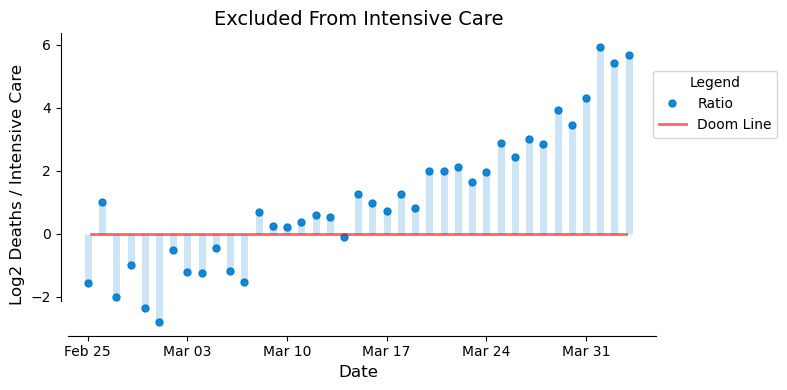

In [71]:
plt.style.use('default')

fig,ax=plt.subplots(figsize=(8,4))

df['log_not_admitted_ratio']=np.log2(df['not_admitted_ratio'])
ax = lollipop_plot(df, ax, date_col='data',
                   value_col='log_not_admitted_ratio')

ax.axhline(0, xmin=0.05,xmax=0.95,
           linewidth=2,
           color='r',alpha=0.6,label='Doom Line')

plt.xlabel('Date', fontsize='12')
plt.ylabel('Log2 Deaths / Intensive Care', fontsize='12')
plt.title('Excluded From Intensive Care', fontsize='14')
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9), title='Legend')
plt.tight_layout()
plt.savefig('Fig2.png')
plt.show()

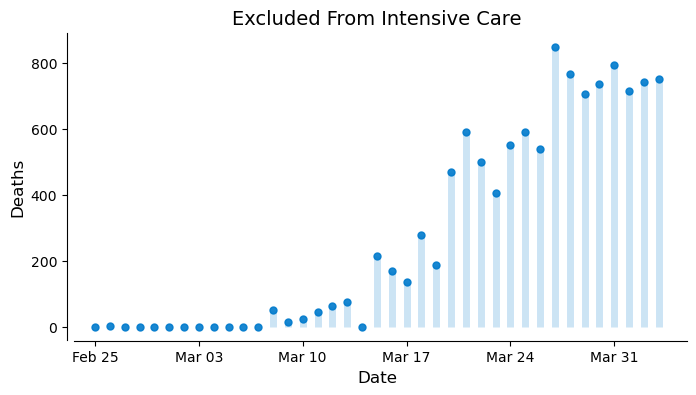

In [72]:
plt.style.use('default')
fig,ax=plt.subplots(figsize=(8,4))
df['not_admitted']=df['not_admitted'].clip(lower=0)
ax = lollipop_plot(df, ax, date_col='data',
                   value_col='not_admitted')

plt.xlabel('Date', fontsize='12')
plt.ylabel('Deaths', fontsize='12')
plt.title('Excluded From Intensive Care', fontsize='14')

#plt.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9), title='Legend')
plt.savefig('Fig3.png')
plt.show()

## Extract UK data

In [73]:
allDf = pd.read_csv('deaths_global.csv')
temp = allDf[(allDf['Country/Region']=='United Kingdom') & (allDf['Lat']==55.3781)  ]
uk_df =  get_country_data(temp)   

## Fig4 
How the Italian and Spanish death trend compare to UK?

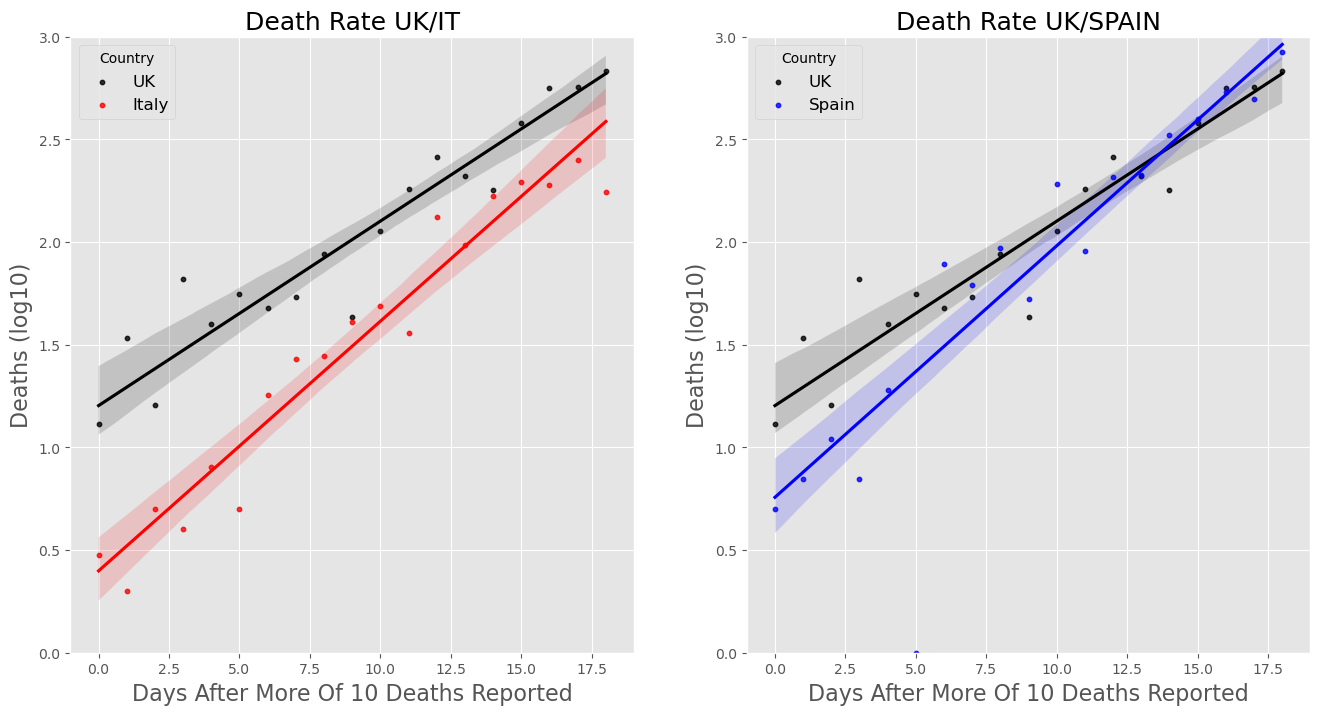

In [74]:
_DEATH_START=10

plt.style.use('ggplot')
fig,axes=plt.subplots(figsize=(16,8),ncols=2)
ax=axes[0]
y='Death_change_log'
uk_df=uk_df[uk_df['Death']>=_DEATH_START]
sns.regplot(x=np.arange(0,uk_df.shape[0]),
            y=y, color="black", data=uk_df,ax=ax,label='UK',
            scatter_kws={'s':10,'marker':'x'},robust=True)

y='deceduti_daily_log'
#temp = df[df['data']<'2020-03-13']
temp = df[~df[y].isna()]
temp = temp[temp['deceduti']>=_DEATH_START]
temp = temp.iloc[:uk_df.shape[0]]

sns.regplot(x=np.arange(0,temp.shape[0]),
            y=y, color="r", data=temp,ax=ax,
            label='Italy',scatter_kws={'s':10},robust=True)

ax.set_xlim(-1,uk_df.shape[0])
ax.set_xlabel('Days After More Of {_DEATH_START} Deaths Reported'.format(_DEATH_START=_DEATH_START)
              , fontsize='16')
ax.set_ylabel('Deaths (log10)',fontsize='16')
ax.set_title('Death Rate UK/IT',fontsize='18')
ax.legend(title='Country',fontsize=12,loc=2)
ax.set_ylim(0,3)

temp = allDf[(allDf['Country/Region']=='Spain')]
spain_df =  get_country_data(temp)
spain_df=spain_df[spain_df['Death']>=_DEATH_START]
spain_df = spain_df.iloc[:uk_df.shape[0]]
ax=axes[1]
y='Death_change_log'
sns.regplot(x=np.arange(0,uk_df.shape[0]),
            y=y, color="black", data=uk_df,ax=ax,label='UK',
            scatter_kws={'s':10,'marker':'x'},robust=True)

sns.regplot(x=np.arange(0,spain_df.shape[0]),
            y=y, color="blue", data=spain_df,ax=ax,label='Spain',
            scatter_kws={'s':10,'marker':'x'},robust=True)


ax.set_xlim(-1,uk_df.shape[0])
ax.set_xlabel('Days After More Of {_DEATH_START} Deaths Reported'.format(_DEATH_START=_DEATH_START)
              , fontsize='16')
ax.set_ylabel('Deaths (log10)',fontsize='16')
ax.set_title('Death Rate UK/SPAIN',fontsize='18')
ax.legend(title='Country',fontsize=12,loc=2)
ax.set_ylim(0,3)
plt.savefig('Fig4.png')
plt.show()

## Fig5
How Italian and spansh death trend looks like?

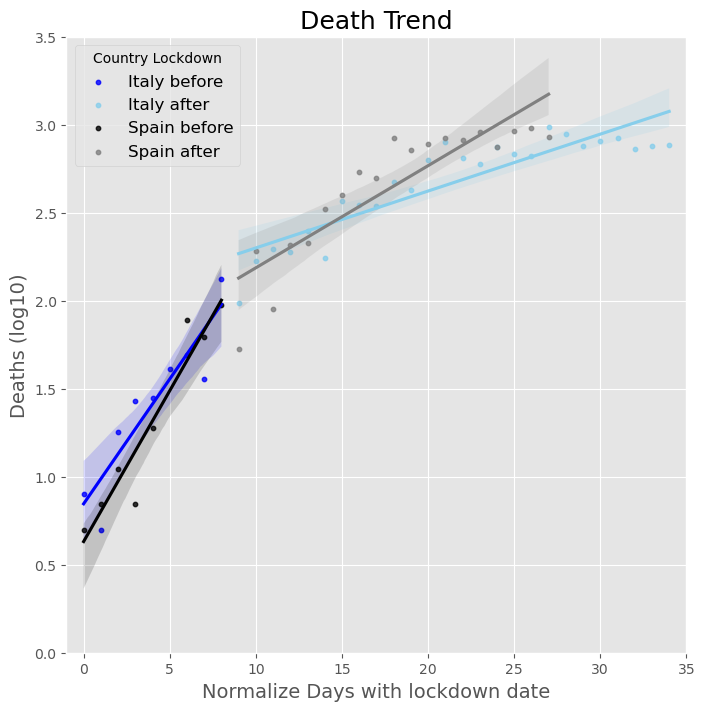

In [76]:
_DEATH_START=10

plt.style.use('ggplot')
before = df[  (df['data']<'2020-03-9')]
before = before[before['deceduti']>=_DEATH_START]
before = before.iloc[4:,:]
before['ndata']=np.arange(0,before.shape[0])

after = df[df['data']>='2020-03-9']
after['ndata']=np.arange(before.shape[0],before.shape[0]+after.shape[0])



max_list = []


x='ndata'
y='deceduti_daily_log'
fig,ax=plt.subplots(figsize=(8,8))
sns.regplot(x=x, y=y, color="b", data=before,ax=ax,label='Italy before',
            scatter_kws={'s':10,'marker':'X'})
sns.regplot(x=x, y=y, color="skyblue", data=after,ax=ax,label='Italy after',
            scatter_kws={'s':10,'marker':'x'})

max_list.append(after['ndata'].max())

temp = allDf[(allDf['Country/Region']=='Spain')]
spain_df =  get_country_data(temp)

before = spain_df[spain_df['date']<'2020-03-16']
before=before[before['Death']>=_DEATH_START]
before['Death_change_log']=before['Death_change_log'].replace(0,np.nan)
before['ndata']=np.arange(0,before.shape[0])

after = spain_df[spain_df['date']>='2020-03-16']
after['ndata']=np.arange(before.shape[0],before.shape[0]+after.shape[0])

x='ndata'
y='Death_change_log'
sns.regplot(x=x, y=y, color="black", data=before,ax=ax,label='Spain before',
            scatter_kws={'s':10,'marker':'x'})
sns.regplot(x=x, y=y, color="gray", data=after,ax=ax,label='Spain after',
            scatter_kws={'s':10,'marker':'x'})

max_list.append(after['ndata'].max())

#_,_=format_x_date(ax)
#plt.xticks(rotation=70,ha='right')
ax.set_xlim(-1,max(max_list)+1)
ax.set_xlabel('Normalize Days with lockdown date'
              , fontsize='14')

plt.ylabel('Deaths (log10)',fontsize='14')
plt.title('Death Trend',fontsize='18')
plt.legend(title='Country Lockdown',fontsize=12)
ax.set_ylim(0,3.5)
plt.savefig('Fig5.png')
plt.show()

In [ ]:
!jupyter nbconvert --to html_toc DataVis.ipynb

In [ ]:
!git add DataVis*
!git add Fig**
!git add -u
!git commit -m 'update'
!git push -u origin master